In [40]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

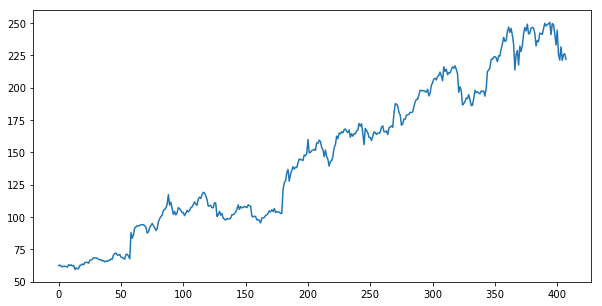

In [41]:
dataset = pandas.read_csv('HistoricalQuotes.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[850::]
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()

In [42]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [43]:
# load the dataset
dataset = pandas.read_csv('HistoricalQuotes.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[850::]
#dataset = dataframe.values
dataset = dataset.astype('float32')

In [44]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [45]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

273 135


In [46]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [47]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
trainX.shape

(257, 15)

In [49]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [50]:
trainX.shape

(257, 1, 15)

In [51]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(30, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 1s - loss: 0.0132
Epoch 2/50
 - 1s - loss: 0.0019
Epoch 3/50
 - 1s - loss: 0.0016
Epoch 4/50
 - 1s - loss: 0.0014
Epoch 5/50
 - 1s - loss: 0.0013
Epoch 6/50
 - 1s - loss: 0.0011
Epoch 7/50
 - 1s - loss: 0.0010
Epoch 8/50
 - 1s - loss: 8.4408e-04
Epoch 9/50
 - 1s - loss: 8.8480e-04
Epoch 10/50
 - 1s - loss: 7.3790e-04
Epoch 11/50
 - 1s - loss: 7.2202e-04
Epoch 12/50
 - 1s - loss: 7.2759e-04
Epoch 13/50
 - 1s - loss: 7.0847e-04
Epoch 14/50
 - 1s - loss: 6.3697e-04
Epoch 15/50
 - 1s - loss: 6.3998e-04
Epoch 16/50
 - 1s - loss: 5.9446e-04
Epoch 17/50
 - 1s - loss: 7.0356e-04
Epoch 18/50
 - 1s - loss: 6.1180e-04
Epoch 19/50
 - 1s - loss: 5.6182e-04
Epoch 20/50
 - 1s - loss: 5.8125e-04
Epoch 21/50
 - 1s - loss: 5.6627e-04
Epoch 22/50
 - 1s - loss: 6.2497e-04
Epoch 23/50
 - 1s - loss: 5.2165e-04
Epoch 24/50
 - 1s - loss: 5.5835e-04
Epoch 25/50
 - 1s - loss: 5.4953e-04
Epoch 26/50
 - 1s - loss: 5.4654e-04
Epoch 27/50
 - 1s - loss: 5.2882e-04
Epoch 28/50
 - 1s - loss: 6.2599e-04
E

In [52]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.26 RMSE
Test Score: 6.15 RMSE


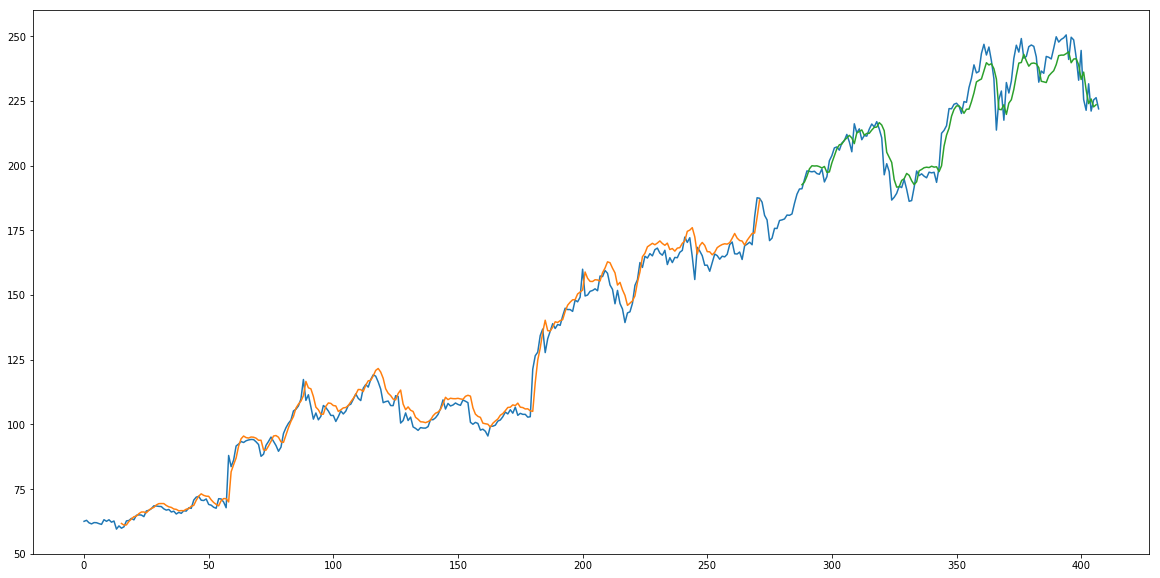

In [53]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [54]:
train2 = dataset
trainX2, trainY2 = create_dataset(train2, look_back)
trainX2 = numpy.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
trainX2.shape, trainY2.shape

((392, 1, 15), (392,))

In [55]:
model2 = Sequential()
model2.add(LSTM(30, input_shape=(1, look_back)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX2, trainY2, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 2s - loss: 0.0213
Epoch 2/50
 - 1s - loss: 0.0021
Epoch 3/50
 - 1s - loss: 0.0017
Epoch 4/50
 - 1s - loss: 0.0017
Epoch 5/50
 - 1s - loss: 0.0014
Epoch 6/50
 - 1s - loss: 0.0014
Epoch 7/50
 - 1s - loss: 0.0012
Epoch 8/50
 - 1s - loss: 0.0011
Epoch 9/50
 - 1s - loss: 0.0012
Epoch 10/50
 - 1s - loss: 0.0011
Epoch 11/50
 - 1s - loss: 9.4174e-04
Epoch 12/50
 - 1s - loss: 8.7973e-04
Epoch 13/50
 - 1s - loss: 0.0010
Epoch 14/50
 - 1s - loss: 0.0010
Epoch 15/50
 - 1s - loss: 8.6328e-04
Epoch 16/50
 - 1s - loss: 9.5565e-04
Epoch 17/50
 - 1s - loss: 8.6798e-04
Epoch 18/50
 - 1s - loss: 8.5132e-04
Epoch 19/50
 - 1s - loss: 9.3352e-04
Epoch 20/50
 - 1s - loss: 8.7998e-04
Epoch 21/50
 - 1s - loss: 7.6557e-04
Epoch 22/50
 - 1s - loss: 8.6461e-04
Epoch 23/50
 - 1s - loss: 7.9482e-04
Epoch 24/50
 - 1s - loss: 8.8084e-04
Epoch 25/50
 - 1s - loss: 8.3872e-04
Epoch 26/50
 - 1s - loss: 7.4816e-04
Epoch 27/50
 - 1s - loss: 8.3864e-04
Epoch 28/50
 - 1s - loss: 7.7256e-04
Epoch 29/50
 - 1s - l

In [56]:
# make predictions
trainPredict2 = model2.predict(trainX2)
# invert predictions
trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY2 = scaler.inverse_transform([trainY2])
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY2, trainPredict2.T))
print('Train Score2: %.2f RMSE' % (trainScore2))

Train Score2: 4.40 RMSE


In [57]:
trainY2.shape, trainPredict2.shape

((1, 392), (392, 1))

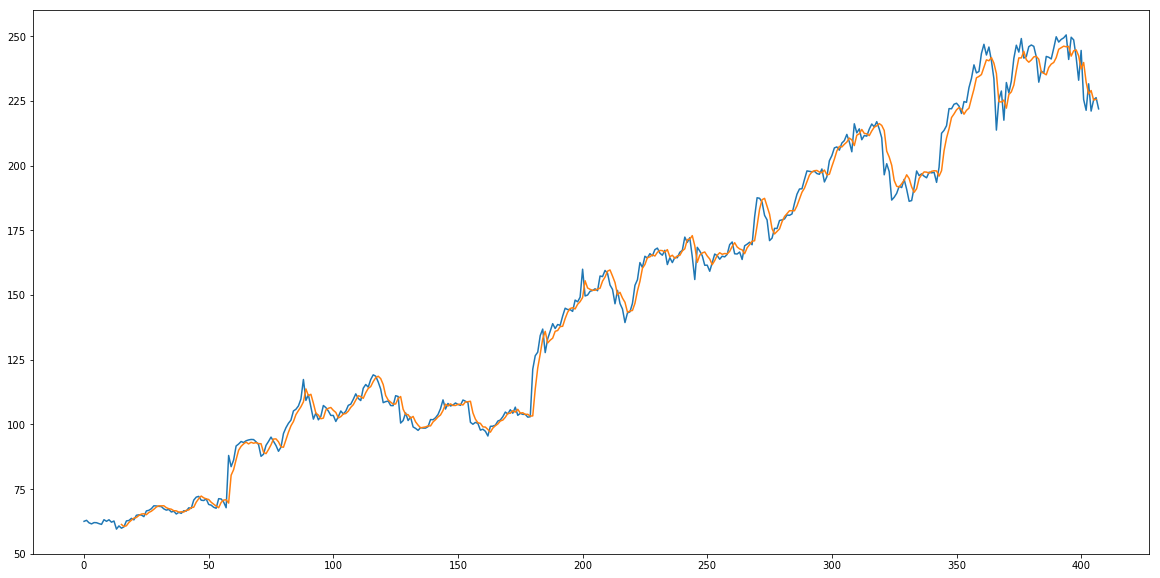

In [58]:
# shift train predictions for plotting
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot2)
plt.show()

In [59]:
import pandas as pd
#from plotly.plotly import plot_mpl
#from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
#trainPredict2 = pd.DataFrame(trainPredict2)
#result = seasonal_decompose(trainPredict2, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

In [61]:
numpy.savetxt("LSTM_Predicted.csv", trainPredict2, delimiter=",")

In [63]:
stepwise_model = auto_arima(trainPredict2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1701.486, BIC=1721.342, Fit time=3.165 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1820.142, BIC=1836.027, Fit time=0.738 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1720.206, BIC=1736.091, Fit time=2.123 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1703.486, BIC=1727.313, Fit time=3.691 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1913.348, BIC=1929.233, Fit time=0.330 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1703.485, BIC=1727.313, Fit time=13.175 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1705.486, BIC=1733.285, Fit time=4.282 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1702.380, BIC=1726.208, Fit time=4.452 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_ord

In [64]:
print(stepwise_model.aic())

1695.51589822


In [65]:
n_periods = 30
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(trainPredict2,future_forecast)

[ 226.97557643  226.62534557  227.26241001  228.31190749  228.93532997
  229.33988201  229.8247742   229.67300346  229.68903863  230.05173786
  230.48525357  230.39196695  231.1019801   230.76257215  231.34084381
  232.36681842  233.00300064  233.41445201  233.89022906  233.72800787
  233.7397542   234.10012886  234.52928472  234.430374    235.13529303
  234.79142431  235.36516752  236.38634213  237.01768891  237.42440636]


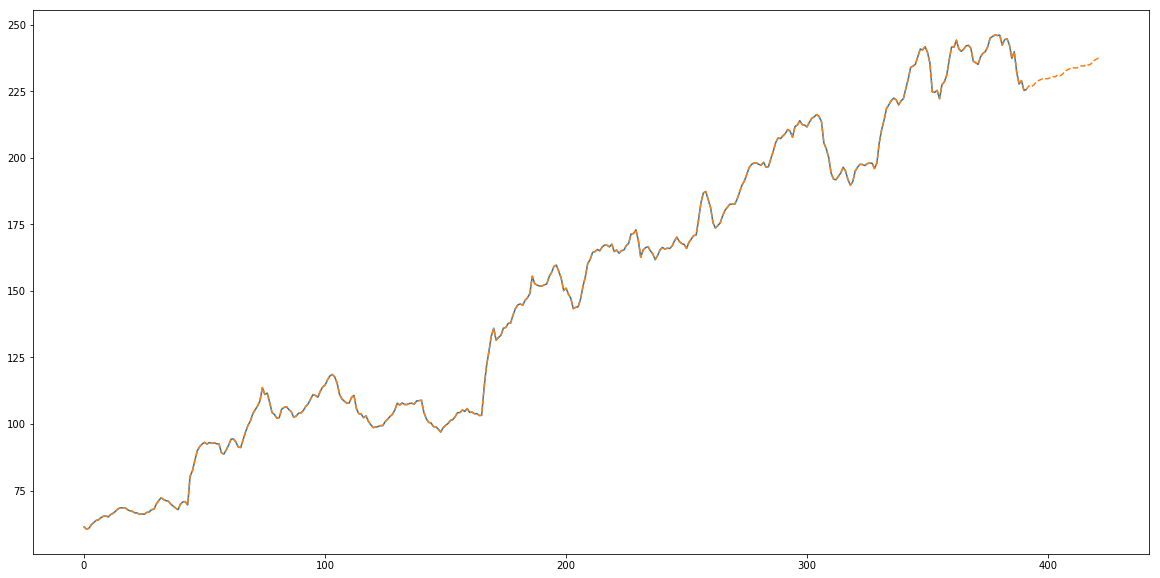

In [66]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict2)
plt.plot(trainPredict2full, '--')
plt.show()